# Variational Autoencoder

This scripts contains module for implementing variational autoencoder, the module contains:
1. mnist_loader: loads mnist data, which will be used for this project
2. xavier_init: initialize weights for vae
3. vae_init: build variational autoencoder, return a tensorflow session

### import libraries

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import time
%matplotlib inline

### mnist_loader

In [2]:
FLAGS = tf.app.flags.FLAGS
# number of device count
tf.app.flags.DEFINE_integer('num_cpu_core', 2, 'Number of CPU cores to use')
tf.app.flags.DEFINE_integer('intra_op_parallelism_threads', 4, 'How many ops can be launched in parallel')
tf.app.flags.DEFINE_integer('num_gpu_core', 0, 'Number of GPU cores to use')

device_id = -1 # Global Variable Counter for device_id used

def next_device(use_cpu = True):
    ''' See if there is available next device;
        Args: use_cpu, global device_id
        Return: new device id
    '''
    global device_id
    if (use_cpu):
        if ((device_id + 1) < FLAGS.num_cpu_core):
            device_id += 1
        device = '/cpu:%d' % device_id
    else:
        if ((device_id + 1) < FLAGS.num_gpu_core):
            device_id += 1
        device = '/gpu:%d' % device_id
    return device

In [3]:
def mnist_loader():
    """
    Load MNIST data in tensorflow readable format
    The script comes from:
    https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/examples/tutorials/mnist/input_data.py
    """
    import gzip
    import os
    import tempfile
    import numpy
    from six.moves import urllib
    from six.moves import xrange
    from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
    
    mnist = read_data_sets('MNIST_data', one_hot=True)
    n_samples = mnist.train.num_examples
    
    return (mnist, n_samples)

In [4]:
(mnist, n_samples) = mnist_loader()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Test mnist data

In [5]:
print('Number of available data: %d' % n_samples)

Number of available data: 55000


We are generating synthetic data in this project, so all the 55000 samples can be used for training

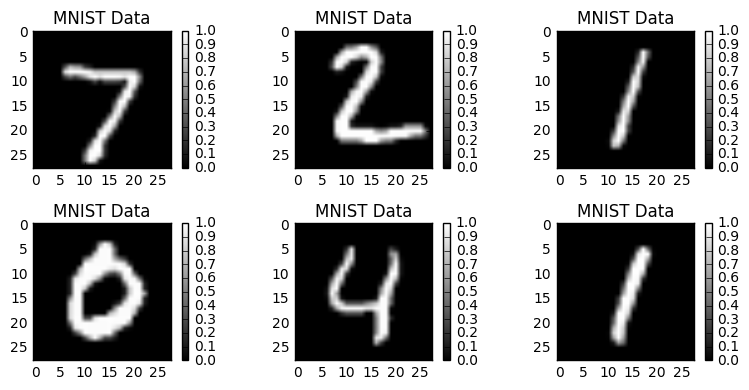

In [6]:
x_sample = mnist.test.next_batch(100)[0]

plt.figure(figsize=(8, 4))
for i in range(6):

    plt.subplot(2, 3, i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("MNIST Data")
    plt.colorbar()
plt.tight_layout()

### xavier_init 

This function helps us to set initial weights properly to prevent the updates in deep layers to be too small or too large. In this implementation, we'll sample the weights from a uniform distribution:  
$\mathbf{W} \ \sim \ uniform(-\sqrt{\frac{6}{\#Neuron_{in}+\#Neuron_{out}}},\sqrt{\frac{6}{\#Neuron_{in}+\#Neuron_{out}}})$

More detailed explanations of why we use xavier initialization can be found [here](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization)

In [7]:
def xavier_init(neuron_in, neuron_out, constant=1):
    low = -constant*np.sqrt(6/(neuron_in + neuron_out))
    high = constant*np.sqrt(6/(neuron_in + neuron_out))
    return tf.random_uniform((neuron_in, neuron_out), minval=low, maxval=high, dtype=tf.float32)

### Test xavier_init

For a 3*3 neural network, the weights should be sampled from uniform(-1,1)

In [8]:
sess_ = tf.Session()
weights = []

for i in range(1000):
    weights.append(sess_.run(xavier_init(3,3)))

weights = np.array(weights).reshape((-1,1))

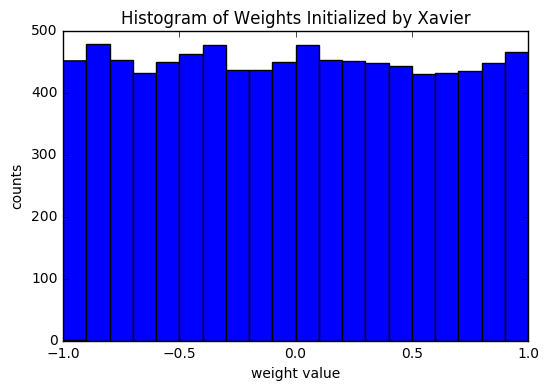

In [9]:
n, bins, patches = plt.hist(weights, bins=20)

plt.xlabel('weight value')
plt.ylabel('counts')
plt.title('Histogram of Weights Initialized by Xavier')
plt.show()

### vae_init
This function initialize a variational encoder, returns tensorflow session, optimizer, cost function and input data will be returned (for further training)
The architecture can be defined by setting the parameters of the function, the default setup is:
- input nodes: 784
- 1st layer of encoder: 500
- 2nd layer of encoder: 500
- 1st layer of decoder: 500
- 2nd layer of decoder: 500
- z: 20

In [14]:
def vae_init(batch_size=100, learn_rate=0.001, x_in=784, encoder_1=500, encoder_2=500, decoder_1=500, decoder_2=500, z=20):
    """
    This function build a varational autoencoder based on https://jmetzen.github.io/2015-11-27/vae.html
    In consideration of simplicity and future work on optimization, we removed the class structure
    A tensorflow session, optimizer and cost function as well as input data will be returned
    """
    # configuration of network
    # x_in = 784
    # encoder_1 = 500
    # encoder_2 = 500
    # decoder_1 = 500
    # decoder_2 = 500
    # z = 20
    
    # input
    x = tf.placeholder(tf.float32, [None, x_in])
    
    # initialize weights
    # two layers encoder
    encoder_h1 = tf.Variable(xavier_init(x_in, encoder_1))
    encoder_h2 = tf.Variable(xavier_init(encoder_1, encoder_2))
    encoder_mu = tf.Variable(xavier_init(encoder_2, z))
    encoder_sigma = tf.Variable(xavier_init(encoder_2, z))
    encoder_b1 = tf.Variable(tf.zeros([encoder_1], dtype=tf.float32))
    encoder_b2 = tf.Variable(tf.zeros([encoder_2], dtype=tf.float32))
    encoder_bias_mu = tf.Variable(tf.zeros([z], dtype=tf.float32))
    encoder_bias_sigma = tf.Variable(tf.zeros([z], dtype=tf.float32))
    # two layers decoder
    decoder_h1 = tf.Variable(xavier_init(z, decoder_1))
    decoder_h2 = tf.Variable(xavier_init(decoder_1, decoder_2))
    decoder_mu = tf.Variable(xavier_init(decoder_2, x_in))
    decoder_sigma = tf.Variable(xavier_init(decoder_2, x_in))
    decoder_b1 = tf.Variable(tf.zeros([decoder_1], dtype=tf.float32))
    decoder_b2 = tf.Variable(tf.zeros([decoder_2], dtype=tf.float32))
    decoder_bias_mu = tf.Variable(tf.zeros([x_in], dtype=tf.float32))
    decoder_bias_sigma = tf.Variable(tf.zeros([x_in], dtype=tf.float32))
    
    # compute mean and sigma of z
    with tf.device(next_device()):
        layer_1 = tf.nn.softplus(tf.add(tf.matmul(x, encoder_h1), encoder_b1))
    with tf.device(next_device()):
        layer_2 = tf.nn.softplus(tf.add(tf.matmul(layer_1, encoder_h2), encoder_b2))
    z_mean = tf.add(tf.matmul(layer_2, encoder_mu), encoder_bias_mu)
    z_sigma = tf.add(tf.matmul(layer_2, encoder_sigma), encoder_bias_sigma)
    
    # compute z by drawing sample from normal distribution
    eps = tf.random_normal((batch_size, z), 0, 1, dtype=tf.float32)
    z_val = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_sigma)), eps))
    
    # use z to reconstruct the network
    with tf.device(next_device()):
        layer_1 = tf.nn.softplus(tf.add(tf.matmul(z_val, decoder_h1), decoder_b1))
    with tf.device(next_device()):
        layer_2 = tf.nn.softplus(tf.add(tf.matmul(layer_1, decoder_h2), decoder_b2))
    x_prime = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, decoder_mu), decoder_bias_mu))
    
    # define loss function
    # reconstruction lost
    recons_loss = -tf.reduce_sum(x * tf.log(1e-10 + x_prime) + (1-x) * tf.log(1e-10 + 1 - x_prime), 1)
    # KL distance
    latent_loss = -0.5 * tf.reduce_sum(1 + z_sigma - tf.square(z_mean) - tf.exp(z_val), 1)
    # summing two loss terms together
    cost = tf.reduce_mean(recons_loss + latent_loss)
    
    # use ADAM to optimize
    optimizer = tf.train.AdamOptimizer(learning_rate=learn_rate).minimize(cost)
    
    # initialize all variables
    init = tf.global_variables_initializer()
    
    #
    config_ = tf.ConfigProto(device_count={"CPU": FLAGS.num_cpu_core}, # limit to num_cpu_core CPU usage  
                inter_op_parallelism_threads = 0,   
                intra_op_parallelism_threads = FLAGS.intra_op_parallelism_threads,  
                log_device_placement=True)  
    # define and return the session
    sess = tf.Session(config=config_)
    sess.run(init)
    
    return (sess, optimizer, cost, x, x_prime)

### vae_train
This function loads the previously initialized VAE and do the training.   
If verbose if set as 1, then every verb_step the program will print out cost information

In [11]:
def vae_train(sess, optimizer, cost, x, batch_size=100, learn_rate=0.001, x_in=784, encoder_1=500, encoder_2=500, decoder_1=500, 
              decoder_2=500, z=20, train_epoch=10, verb=1, verb_step=5):
    start_time = time.time()
    
    for epoch in range(train_epoch):
        avg_cost = 0
        total_batch = int(n_samples / batch_size)
        for i in range(total_batch):
            
            batch_x, _ = mnist.train.next_batch(batch_size)
            
            _, c = sess.run((optimizer, cost), feed_dict={x: batch_x})
            avg_cost += c / n_samples * batch_size
            elapsed_time = (time.time() - start_time)* 1000 / verb_step
            start_time = time.time()
        
        if verb:
            if epoch % verb_step == 0:
                # print('Epoch:%04d\tCost=%.2f' % (epoch+1, avg_cost))
                print('Epoch:%04d' % (epoch+1), 'cost=', '{:.9f}'.format(avg_cost), 'Elapsed time: ','%.9f' % elapsed_time)

In [12]:
(sess, optimizer, cost, x, x_prime) = vae_init()

/cpu:1


In [13]:
vae_train(sess, optimizer, cost, x, train_epoch=75)

Epoch:0001 cost= 202.664233287 Elapsed time:  2.729892731
Epoch:0006 cost= 125.766260529 Elapsed time:  2.569389343
Epoch:0011 cost= 119.852241474 Elapsed time:  2.786922455


KeyboardInterrupt: 

In [ ]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = sess.run(x_prime,  feed_dict={x: x_sample})

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()
sess.close()